In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import torch

from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import f1_score

import generators as gen
import optimize as opt
import helpers as hel
from NNet import NNet

%load_ext autoreload
%autoreload 2

import os

# Graph learning on SBM
Create stochastic block model with 30 nodes

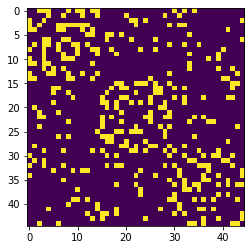

In [2]:
L = gen.generate_L_sbm(45, p_in=.3, p_out=.1, n_blocks=3)
plt.imshow(L<0);

In [3]:
def generate_and_infer(L, ker, n_samples=500, **kwargs):
    """
    Generates sample from kernel, then infers graph and filter.
    """
    samples = gen.gen_and_filter(L, n_samples, ker=ker, seed=42)
    imp,hist,h = opt.impute_graph(samples, **kwargs)
    
    return samples, imp, h, hist


def plot_results(L, ker, imp, h):
    plt.figure(figsize=(16,4))
    plt.subplot(141)
    plt.imshow(L<0)
    plt.title('True Adjacency')
    plt.axis('off')
    
    dens = (L<0).sum()/L.shape[0]**2
    
    plt.subplot(142)
    plt.imshow(imp>=np.quantile(imp, 1-dens))
    plt.title('Rounded Imputed Values')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(imp)
    plt.title('Imputed Values')
    plt.axis('off')

    plt.subplot(144)
    evals, _ = np.linalg.eig(L)
    x = torch.Tensor(np.linspace(0.01,evals.max()+1, num=100)).unsqueeze_(-1)
    plt.plot(x.numpy(), h(x).detach().numpy())
    plt.plot(evals, ker(torch.Tensor(evals)), 'ro')
    plt.legend(['Fitted', 'True'])
    plt.xlabel('Eigenvalue')
    plt.ylabel('Kernel');

    print('F1 Score:', f1_score(np.array(L<0).flatten(), (imp>.5).flatten()))

### Normal kernel

In [4]:
#h = NNet(3, 30)
ker = gen.kernel_normal

In [5]:
h = NNet(5, 30)
samples, imp, h, hist = generate_and_infer(L, ker, verbose=100, lr=100, h_start=h,
                                           n_epochs=2000, lr_nnet=1e-3, nit_nnet=5)

[Epoch 2000/2000] loss: 0.041950

F1 Score: 0.8597560975609757


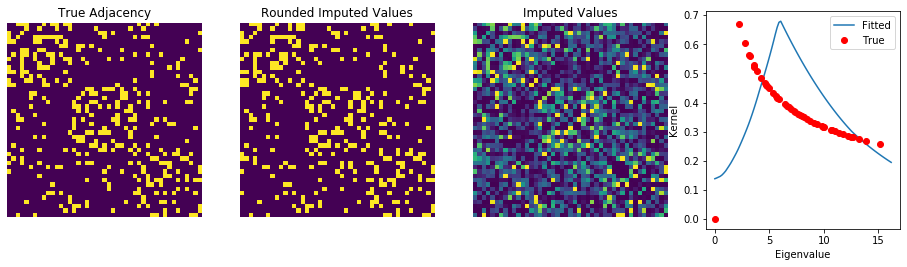

In [6]:
plot_results(L, ker, imp, h)
plt.savefig('res/impute_normal.png')

### Heat kernel

In [7]:
ker = lambda x: gen.kernel_heat(x, alpha=.1)

In [8]:
h = NNet(5, 30)
samples, imp, h, hist = generate_and_infer(L, ker, verbose=100, lr=10, 
                                           n_epochs=2000, lr_nnet=1e-3, nit_nnet=1)

[Epoch 2000/2000] loss: 0.142346

F1 Score: 0.962962962962963


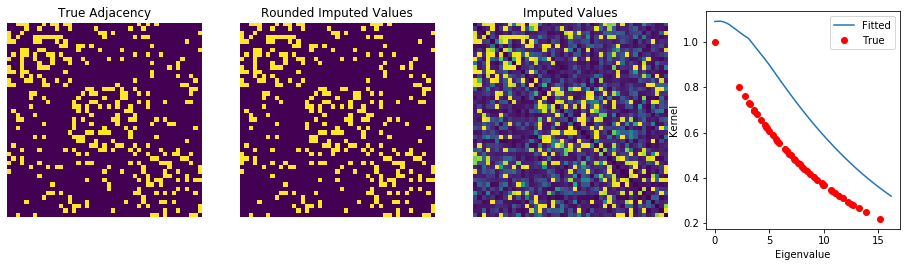

In [9]:
plot_results(L, ker, imp, h)
plt.savefig('res/impute_heat.png')

### Highpass Filter

In [12]:
ker = lambda x: gen.kernel_highpass(x, par=.5)

In [13]:
h = NNet(5, 30)
samples, imp, h, hist = generate_and_infer(L, ker, verbose=100, lr=10, h_start=h,
                                           n_epochs=10000, lr_nnet=1e-3, nit_nnet=1)

[Epoch 10000/10000] loss: 0.023629

F1 Score: 0.5846153846153846


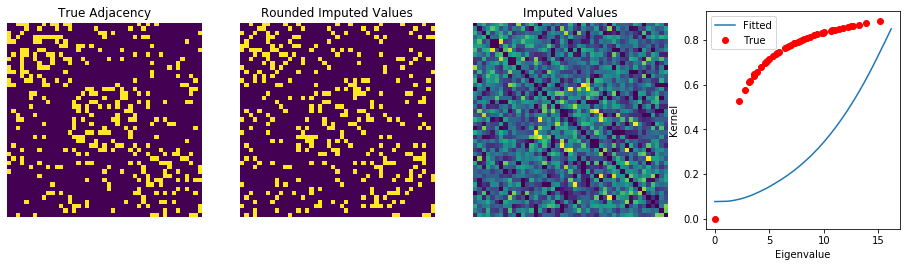

In [14]:
plot_results(L, ker, imp, h)
plt.savefig('res/impute_hp.png')